## Data import

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_data = pd.read_csv("/content/gdrive/My Drive/NDSC2019/data/train.csv")

In [0]:
train_data['title'].sample(20)

524722    promo khusus hari ini chat wa 085285720089 bel...
630670                            iphone 6 128gb space gray
122023    l ed original 100 maybelline fit me loose fini...
556813         xiaomi mi5s plus ram 6gb 128gb original bnib
4022         maybelline 3in 1 ungu new nuevo lash blast 24h
144277    bioaqua exquisite and delicate bb cc cushion p...
414857    dress kemeja denim wanita lengan panjang denga...
375055                  dress wrap long sleeve terbaru 2016
84854     best produk wardah bb lightening cake powder b...
97748                                       aprilskin bedak
589164              camera connection kid ipad otg 5+1 in 1
110180    terbaru laneige bb cushion pore control lucky ...
518970    xiomi redmi note 2 gb ram 16gb rom 4g lte gara...
511172                samsung j4 plus ram 2gb rom 32gb sein
216178    miss rose stik contour concealer highlighter s...
510107    promo iphone x 16gb garansi resmi apple 1 tahu...
118237      terupdate immortal cc cream 

#### Text cleanning function

In [0]:
import re
def clean_text(sentence):
  cleaned = sentence
  ## Remove numbers/words contain number
  cleaner = lambda x : re.sub('^\d|\.|-|_', '', x)
  #cleaned = re.sub('[^a-zA-Z ]', '', cleaned)
  words = cleaned.split()
  cleaned = ' '.join([cleaner(word) for word in words if len(word) > 1])
  return cleaned

## Classes distribution

In [5]:
category_counts = train_data['Category'].value_counts()
max_counts = max(np.array(category_counts))
print(max_counts)
np.array(category_counts)

81250


array([81250, 56598, 55279, 42688, 33922, 33845, 30590, 29754, 28670,
       27836, 21782, 19978, 19312, 16199, 15225, 14718, 13493, 11668,
       11544, 10502, 10483,  8106,  6493,  6147,  6048,  4821,  4703,
        4251,  4108,  3772,  3338,  2982,  2765,  2735,  2272,  2228,
        2195,  2047,  1671,  1441,  1077,  1028,   945,   920,   697,
         684,   599,   573,   418,   416,   404,   327,   300,   282,
         170,   151,   117,    48])

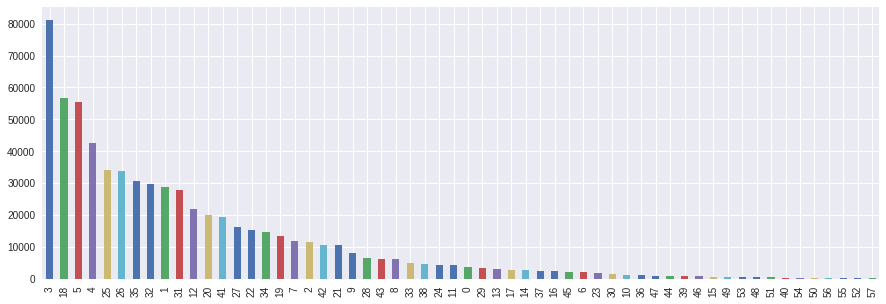

In [6]:
plt.figure(figsize=(15,5))
category_counts.plot('bar')

## Classification model

In [9]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPool1D, Input, Activation, Reshape, Flatten, Dropout, CuDNNLSTM, Bidirectional, BatchNormalization, LSTM
from keras.optimizers import Adam, sgd
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [10]:
train_data.shape

(666615, 4)

In [0]:
text = train_data['title']
text = text.apply(clean_text)
y = train_data['Category']

In [12]:
text.shape

(666615,)

In [0]:
from sklearn.model_selection import train_test_split

## Set test_size 0.20 for validation
text_train, text_val, y_train, y_val = train_test_split(text, y, test_size=0.2, random_state = 101)

In [14]:
print(text_train.shape)
print(text_val.shape)
print(y_val.shape)

(533292,)
(133323,)
(133323,)


In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)

In [0]:
X_train_seq = tokenizer.texts_to_sequences(text_train)
X_val_seq = tokenizer.texts_to_sequences(text_val)

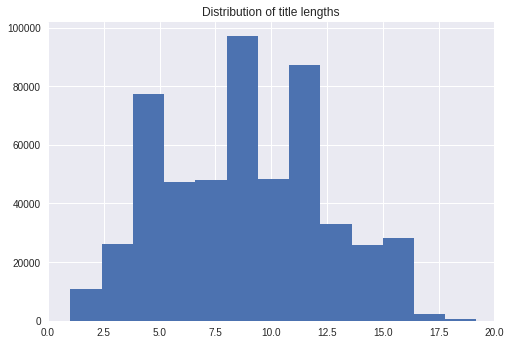

In [17]:
sentence_length = [len(x.split()) for x in text_train]
plt.hist(sentence_length, bins = 20)
plt.title('Distribution of title lengths')
plt.xlim((0,20))
plt.show()

In [0]:
max_length = 20
X_train = pad_sequences(X_train_seq, maxlen=max_length)
X_val = pad_sequences(X_val_seq, maxlen=max_length)

In [19]:
len(tokenizer.word_counts)

67078

In [0]:
import gensim
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/NDSC2019/data/word2vec_300d_combined.txt', binary=False)

In [0]:
vocabulary_size = len(tokenizer.word_counts)

def load_embedding(model_keyedVectors):
  embedding_matrix = np.zeros((vocabulary_size,300))
  for word, index in tokenizer.word_index.items():
      if index > vocabulary_size - 1:
          break
      else:
          if word in model_keyedVectors.vocab:
              embedding_vector = model_keyedVectors.get_vector(word)
              embedding_matrix[index] = embedding_vector
  return embedding_matrix

In [0]:
embedding_matrix = load_embedding(word_vectors)

In [0]:
vocabulary_size = len(tokenizer.word_counts)
model = Sequential()
model.add(Embedding(vocabulary_size, 300, input_length=max_length, weights=[embedding_matrix], trainable=False))
model.add(Dropout(0.4))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Bidirectional(CuDNNLSTM(500)))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(58, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [32]:
history = model.fit(X_train, y_train, epochs=50, batch_size=512*2, validation_data=[X_val, y_val], verbose = 1,callbacks=None)

Train on 533292 samples, validate on 133323 samples
Epoch 1/50
533292/533292 [==============================] - 110s 206us/step - loss: 1.4173 - acc: 0.6092 - val_loss: 1.0413 - val_acc: 0.6842
Epoch 2/50
533292/533292 [==============================] - 108s 203us/step - loss: 1.1216 - acc: 0.6734 - val_loss: 0.9871 - val_acc: 0.6951
Epoch 3/50
533292/533292 [==============================] - 108s 203us/step - loss: 1.0651 - acc: 0.6848 - val_loss: 0.9558 - val_acc: 0.7035
Epoch 4/50
533292/533292 [==============================] - 108s 203us/step - loss: 1.0297 - acc: 0.6925 - val_loss: 0.9327 - val_acc: 0.7071
Epoch 5/50
533292/533292 [==============================] - 109s 205us/step - loss: 1.0013 - acc: 0.6989 - val_loss: 0.9175 - val_acc: 0.7128
Epoch 6/50
533292/533292 [==============================] - 111s 208us/step - loss: 0.9762 - acc: 0.7041 - val_loss: 0.9034 - val_acc: 0.7146
Epoch 7/50
533292/533292 [==============================] - 111s 208us/step - loss: 0.9547 - acc

KeyboardInterrupt: ignored

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 300)           20123400  
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 300)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 128)           115328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 128)           512       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000)              2520000   
_________________________________________________________________
dense_4 (Dense)              (None, 300)               300300    
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
__________

#### model analysis

In [0]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [0]:
history.history['acc']

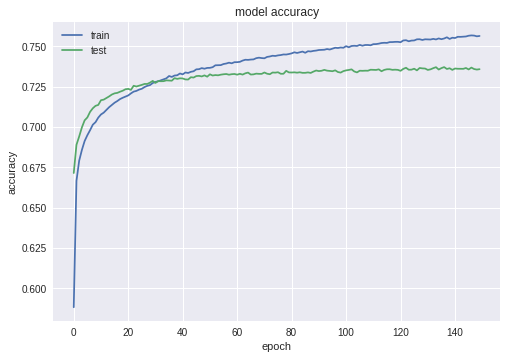

In [0]:
# summarize history for accuracy
# training and test accuracy vs epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training(80%)', 'validation(20%)'], loc='upper left')
plt.show()


In [0]:
# summarize history for loss
# training loss and testing loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save("/content/gdrive/My Drive/NDSC2019/code/text_model_0_75458.h5")

In [0]:
from sklearn.metrics import classification_report, f1_score

In [0]:
y_val_predict = model.predict_classes(X_val)

In [0]:
print(classification_report(y_val, y_val_predict))

## Submission

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model1 = load_model('/content/gdrive/My Drive/NDSC2019/code/text_model_0_75458.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 300)           22661400  
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 300)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 18, 128)           115328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 18, 128)           512       
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1000)              2520000   
_________________________________________________________________
dense_10 (Dense)             (None, 300)               300300    
_________________________________________________________________
dropout_11 (Dropout)         (None, 300)               0         
__________

In [0]:
test_data = pd.read_csv('/content/gdrive/My Drive/NDSC2019/data/test.csv')

In [0]:
test_data.head()

,itemid,title,image_path
0,370855998,flormar 7 white cream bb spf 30 40ml,beauty_image/1588591395c5a254bab84042005f2a9f.jpg
1,637234604,maybelline clear smooth all in one bb cream sp...,beauty_image/920985ed9587ea20f58686ea74e20f93.jpg
2,690282890,murah innisfree eco natural green tea bb cream...,beauty_image/90b40e5710f54352b243fcfb0f5d1d7f.jpg
3,930913462,loreal white perfect day cream spf 17 pa white...,beauty_image/289c668ef3d70e1d929d602d52d5d78a.jpg
4,1039280071,hada labo cc cream ultimate anti aging spf 35 ...,beauty_image/d5b3e652c5822d2306f4560488ec30c6.jpg


In [0]:
test_text = test_data['title']
test_text = test_text.apply(clean_text)
X_test_seq = tokenizer.texts_to_sequences(test_text)
X_test = pad_sequences(X_test_seq, maxlen=20)

In [0]:
y_test = model.predict_classes(X_test, verbose = 1)

172402/172402 [==============================] - 47s 274us/step


In [0]:
y_test

array([ 5,  5,  5, ..., 35, 33, 34])

In [0]:
test_data['Category'] = y_test

In [0]:
submission = test_data[['itemid', 'Category']]

In [0]:
submission.shape

(172402, 2)

In [0]:
submission.to_csv("submission13.csv", index=False)

In [0]:
model1.get_config()

{'layers': [{'class_name': 'Embedding',
   'config': {'activity_regularizer': None,
    'batch_input_shape': (None, 20),
    'dtype': 'float32',
    'embeddings_constraint': None,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'maxval': 0.05, 'minval': -0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'input_dim': 75538,
    'input_length': 20,
    'mask_zero': False,
    'name': 'embedding_4',
    'output_dim': 300,
    'trainable': False}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_10',
    'noise_shape': None,
    'rate': 0.4,
    'seed': None,
    'trainable': True}},
  {'class_name': 'Conv1D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1,),
    'filters': 128,
    'kernel_constraint': None,
    'kernel_initializer': {